In [3]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from imblearn.combine import SMOTEENN

from xgboost.sklearn import XGBClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

sns.set_style("darkgrid")

### QUESTION 1: Using both Regressor and Classifier to model salary ###

1. X = job_description, y = salary
2. Train_Test_Split, CountVectorizer, TFIDF Transformer
3. Use Pipeline, ElasticNet, GridsearchCV
4. Use Pipeline, SGDClassifier, GridsearchCV

In [4]:
df = pd.read_csv('job_results.csv', index_col=0, encoding='utf-8')
df.head()

,job_category,job_title,company_name,location,job_description,salary
0,data scientist,number summer intern data scientist,akamai,"cambridge, ma 02139 (area iv area)",please use google chrome when applying for job...,30000.0
1,data scientist,production control data scientist,tesla motors,"sparks, nv",job title production control data scientist de...,50000.0
2,data scientist,data scientist,microsoft,"bellevue, wa",the microsoft knowledge graph team in the arti...,50000.0
3,data scientist,data scientist,schneider electric,"andover, ma 01810",schneider electrictm creates connected technol...,50000.0
4,data scientist,data scientist,university of chicago,"chicago, il",the university of chicago is an affirmative ac...,50000.0


In [299]:
X = df['job_description']
y = df.salary

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [301]:
stoplist = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

In [302]:
# ElasticNet Regressor - GridSearchCV
start = time.time()

pipeline = Pipeline([
    ('vect', CountVectorizer(decode_error='ignore', ngram_range=(1,1), strip_accents='unicode', \
                             stop_words=stoplist, tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('rgs', ElasticNet())
]) 

params = dict(rgs__alpha=np.linspace(50, 500, 5), rgs__l1_ratio=[0.1, 0.5, 1.0])
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5)

grid_search.fit(X_train, y_train)
print 'best hyper-parameters =', grid_search.best_params_
print 'best score =', grid_search.best_score_
print ''
print 'best estimator =',grid_search.best_estimator_
print ''

end = time.time()
exe_time = (end - start)/60
print 'Time taken :',(exe_time),' minutes'

best hyper-parameters = {'rgs__alpha': 50.0, 'rgs__l1_ratio': 1.0}
best score = 0.376558310352

best estimator = Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error='ignore',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=set([u'al...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

Time taken : 14.3803699334  minutes


In [303]:
print y.value_counts()
print len(y)

90000.0     691
70000.0     596
110000.0    452
50000.0     334
130000.0    279
150000.0    102
30000.0      64
170000.0     13
190000.0      3
10000.0       3
210000.0      1
Name: salary, dtype: int64
2538


In [305]:
# SGD Classifier - GridSearch : y = full salary
start = time.time()

pipeline = Pipeline([
    ('vect', CountVectorizer(decode_error='ignore', ngram_range=(1,1), strip_accents='unicode', \
                             stop_words=stoplist, tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('cls', SGDClassifier(n_jobs=-1, max_iter=5, tol=None))
]) 

params = dict(cls__alpha=np.linspace(0.01, 10, 5), cls__penalty=['l1','l2','elasticnet'], cls__l1_ratio=[0.2, 0.5, 0.8])
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5)

grid_search.fit(X_train, y_train)
print 'best hyper-parameters =', grid_search.best_params_
print 'best score =', grid_search.best_score_
print ''
print 'best estimator =',grid_search.best_estimator_
print ''

end = time.time()
exe_time = (end - start)/60
print 'Time taken :',(exe_time),' minutes'


best hyper-parameters = {'cls__penalty': 'l2', 'cls__alpha': 0.01, 'cls__l1_ratio': 0.5}
best score = 0.39527027027

best estimator = Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error='ignore',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=set([u'al...       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

Time taken : 42.8034679174  minutes


In [314]:
# Alternative approach - create salary category
median = np.median(df.salary)
median

90000.0

In [315]:
sal_cat = []
for s in df.salary:
    if s > median:
        sal_cat.append('High')
    elif s < median:
        sal_cat.append('Low')
    else:
        sal_cat.append('Medium')

In [316]:
df['sal_cat'] = sal_cat
df.head()

,job_category,job_title,company_name,location,job_description,salary,sal_cat
0,data scientist,number summer intern data scientist,akamai,"cambridge, ma 02139 (area iv area)",please use google chrome when applying for job...,30000.0,Low
1,data scientist,production control data scientist,tesla motors,"sparks, nv",job title production control data scientist de...,50000.0,Low
2,data scientist,data scientist,microsoft,"bellevue, wa",the microsoft knowledge graph team in the arti...,50000.0,Low
3,data scientist,data scientist,schneider electric,"andover, ma 01810",schneider electrictm creates connected technol...,50000.0,Low
4,data scientist,data scientist,university of chicago,"chicago, il",the university of chicago is an affirmative ac...,50000.0,Low


In [317]:
df.sal_cat.value_counts()

Low       997
High      850
Medium    691
Name: sal_cat, dtype: int64

In [318]:
X = df['job_description']
y = df.sal_cat

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [324]:
base_accuracy = y_test.value_counts() / len(y_test)
base_accuracy

Low       0.401575
High      0.325459
Medium    0.272966
Name: sal_cat, dtype: float64

In [312]:
# SGD Classifier - GridSearch : y = salary category
start = time.time()

pipeline = Pipeline([
    ('vect', CountVectorizer(decode_error='ignore', ngram_range=(1,1), strip_accents='unicode', \
                             stop_words=stoplist, tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('cls', SGDClassifier(n_jobs=-1, max_iter=5, tol=None))
]) 

params = dict(cls__alpha=np.linspace(0.01, 10, 5), cls__penalty=['l1','l2','elasticnet'], cls__l1_ratio=[0.2, 0.5, 0.8])
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5)

grid_search.fit(X_train, y_train)
print 'best hyper-parameters =', grid_search.best_params_
print 'best score =', grid_search.best_score_
print ''
print 'best estimator =',grid_search.best_estimator_
print ''

end = time.time()
exe_time = (end - start)/60
print 'Time taken :',(exe_time),' minutes'

best hyper-parameters = {'cls__penalty': 'l2', 'cls__alpha': 0.01, 'cls__l1_ratio': 0.2}
best score = 0.610923423423

best estimator = Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error='ignore',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=set([u'al...       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

Time taken : 42.8533349832  minutes


### QUESTION 2: Factors that distinguish job category ###

1. X = job_description + company_name + location, y = job_category
2. TfidfVectorizer followed by Train_Test_Split
3. RandomForestClassifier
4. Determine the top 30 features that distinguish job categories


In [286]:
Stoplist = set(stopwords.words('english') + ['data', 'scientist', 'analyst', 'research', 'business', 'intelligence'] +\
               list(ENGLISH_STOP_WORDS))

In [287]:
vect = TfidfVectorizer(decode_error='ignore', ngram_range=(1,2), strip_accents='unicode', stop_words=Stoplist, \
                      tokenizer=word_tokenize)

In [288]:
X1 = df['job_description']
X2 = df['company_name']
X3 = df['location']
y = df['job_category']

In [ ]:
vect.fit(X1)

In [290]:
X_1 = pd.DataFrame(vect.transform(X1).todense(), columns=vect.get_feature_names())

In [ ]:
vect.fit(X2)

In [292]:
X_2 = pd.DataFrame(vect.transform(X2).todense(), columns=vect.get_feature_names())

In [ ]:
vect.fit(X3)

In [294]:
X_3 = pd.DataFrame(vect.transform(X3).todense(), columns=vect.get_feature_names())

In [295]:
# combining vectorised X1, X2 and X3 into X
X = pd.concat([X_1, X_2, X_3], axis=1)

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [297]:
base_accuracy = y_test.value_counts()/len(y_test)
base_accuracy

data analyst             0.418635
data scientist           0.267717
business intelligence    0.170604
research scientist       0.143045
Name: job_category, dtype: float64

In [304]:
rfc = RandomForestClassifier(max_depth=70)

In [305]:
rfc.fit(X_train, y_train)
y_predicted = rfc.predict(X_test)
print rfc.score(X_test, y_test)

0.643044619423


In [306]:
features = X.columns

In [307]:
feature_imp = rfc.feature_importances_

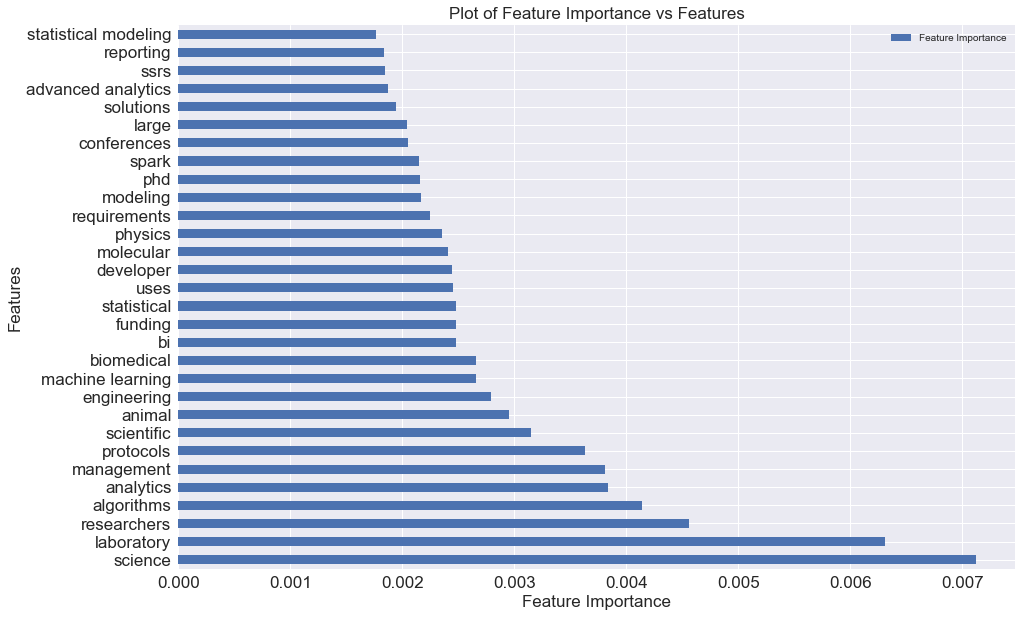

In [308]:
f_rank = zip(features, feature_imp)
    
df1 = pd.DataFrame(f_rank, columns=['Features', 'Feature Importance'])

df1 = df1.sort_values('Feature Importance', ascending=False)

df1[:30].plot(kind='barh', x = 'Features', y = 'Feature Importance', figsize=[15,10], fontsize = 17)
plt.xlabel('Feature Importance', fontsize=17)
plt.ylabel('Features', fontsize=17)
plt.title('Plot of Feature Importance vs Features', fontsize=17)
plt.show()

### Bonus Problem ###

*** Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client 
incorrectly that they would get a high salary job. ***

1. Find median salary
2. Split salary column into High (1) and Low (0). High > median
3. Train_Test_split (X = job_description, y = sal_high_low)
3. Pipeline CountVectorize, TFIDF transform and Logistic Regression estimator
4. Confusion matrix, FP vs FN plot, ROC


In [279]:
sal_median = np.median(df.salary)
sal_median

90000.0

In [280]:
# High salary 1 - higher than median
# Low salary 0 - median or lower

df['sal_high_low'] = df.salary.map(lambda x : 1 if x > sal_median else 0)

In [281]:
df.head()

,job_category,job_title,company_name,location,job_description,salary,sal_high_low
0,data scientist,number summer intern data scientist,akamai,"cambridge, ma 02139 (area iv area)",please use google chrome when applying for job...,30000.0,0
1,data scientist,production control data scientist,tesla motors,"sparks, nv",job title production control data scientist de...,50000.0,0
2,data scientist,data scientist,microsoft,"bellevue, wa",the microsoft knowledge graph team in the arti...,50000.0,0
3,data scientist,data scientist,schneider electric,"andover, ma 01810",schneider electrictm creates connected technol...,50000.0,0
4,data scientist,data scientist,university of chicago,"chicago, il",the university of chicago is an affirmative ac...,50000.0,0


In [282]:
X = df['job_description']
y = df.sal_high_low

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [284]:
len(y_test)

762

In [254]:
stoplist = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

In [255]:
# Logistic Regression
start = time.time()

pipeline = Pipeline([
    ('vect', CountVectorizer(decode_error='ignore', ngram_range=(1,1), strip_accents='unicode', stop_words=stoplist)),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
print pipeline.score(X_test, y_test)

end = time.time()
exe_time = end - start
print 'Time taken :',(exe_time),' seconds'

0.814960629921
Time taken : 2.72261285782  seconds


In [285]:
base_accuracy = 1 - np.mean(y_test)
base_accuracy

0.6732283464566929

In [257]:
print classification_report(y_test, y_predicted)

             precision    recall  f1-score   support

          0       0.81      0.94      0.87       510
          1       0.82      0.56      0.67       252

avg / total       0.82      0.81      0.80       762



In [39]:
# Calculate probability of prediciton
y_proba_df = pd.DataFrame(y_proba, columns=['Low Salary', 'High Salary'])
y_proba_df.head()

,Low Salary,High Salary
0,0.798551,0.201449
1,0.783015,0.216985
2,0.723196,0.276804
3,0.897629,0.102371
4,0.876630,0.123370


In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
print 'Actual Salary Low, Predicted High : ', fp
print 'Actual Salary High, Predicted Low : ', fn

Actual Salary Low, Predicted High :  28
Actual Salary High, Predicted Low :  118


In [43]:
# Create Confusion Matrix
cm = confusion_matrix(y_test, y_predicted, labels=[1,0])

cm_df = pd.DataFrame(cm, index=['High Salary', 'Low Salary'], columns=['Predicted High', 'Predicted Low'])
cm_df

,Predicted High,Predicted Low
High Salary,130,118
Low Salary,28,486


In [63]:
# Set up threshold range and calculate fp and fn
threshold = np.arange(1,100)/100.
fp = []
fn = []

for thresh in threshold:
    labeled_high = np.array([1 if x >= thresh else 0 for x in y_proba_df['High Salary']])
    # print 'Threshold:', thresh, 'false positives:', np.sum((y_test == 0) & (labeled_high == 1)), \
    #                              'false negatives:', np.sum((y_test == 1) & (labeled_high == 0))
    fp.append(np.sum((y_test == 0) & (labeled_high == 1)))
    fn.append(np.sum((y_test == 1) & (labeled_high == 0)))

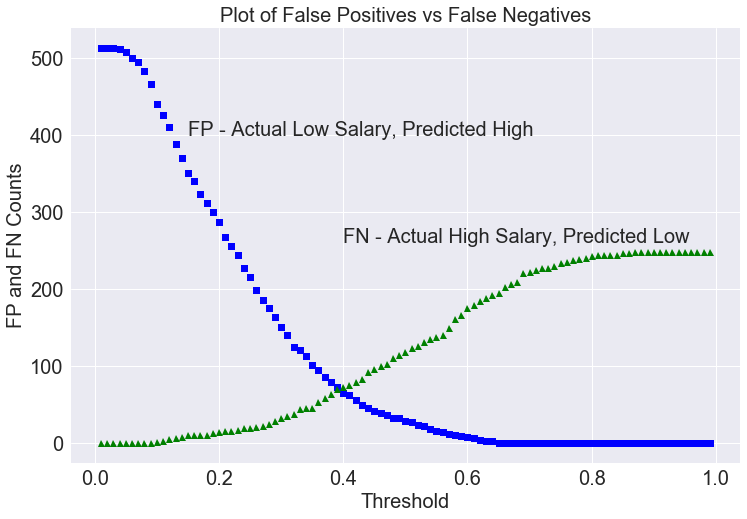

In [69]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()

plt.plot(threshold, fp, 'bs', threshold, fn, 'g^', axes=ax)
plt.title('Plot of False Positives vs False Negatives', fontsize=20)
plt.xlabel('Threshold', fontsize=20)
plt.ylabel('FP and FN Counts', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.15, 400, 'FP - Actual Low Salary, Predicted High', fontsize=20)
plt.text(0.4, 260, 'FN - Actual High Salary, Predicted Low', fontsize=20)

plt.show()

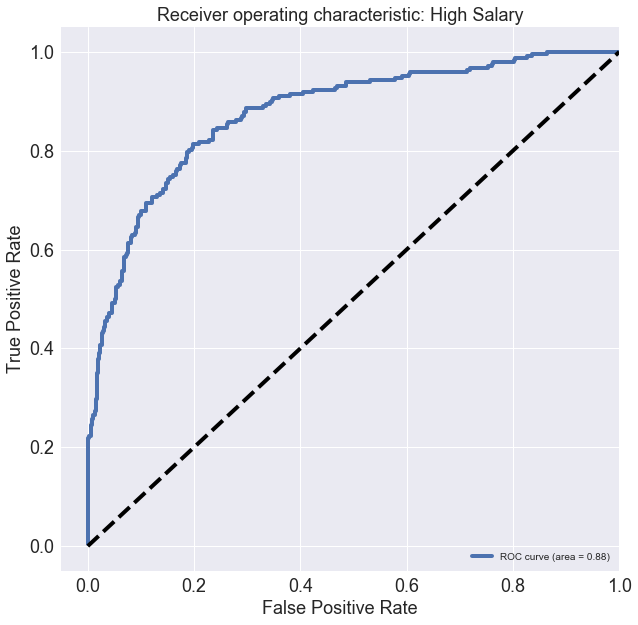

In [68]:
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10,10])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: High Salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()